# Creating a SACC file with the library


In this example we will make a Sacc data file using simulated data from CCL, the Core Cosmology Library.

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sacc
import pyccl as ccl
import datetime
import time

# Getting input data

We will make some fake window ranges and data vectors from theory predictions using CCL.  We will also need fake N(z) distributions in that case.

We will generate 4 bins of galaxy density w(theta) measurements.

In [3]:
galaxy_density_cl = sacc.standard_types.galaxy_density_cl
nbin = 4

We will generate 20 ell bins from ell=5 to ell=1000

In [4]:
ell_edges = np.linspace(5, 1000, 20).astype(int)

# Generate the ranges (ell_min, ell_max)
window_ranges = list(zip(ell_edges[:-1], ell_edges[1:]))
effective_ell = np.array([mean(x) for x in window_ranges])
ell_max = window_ranges[-1][-1]+1
print("Ell window ranges:")
print(window_ranges)

Ell window ranges:
[(5, 57), (57, 109), (109, 162), (162, 214), (214, 266), (266, 319), (319, 371), (371, 423), (423, 476), (476, 528), (528, 581), (581, 633), (633, 685), (685, 738), (738, 790), (790, 842), (842, 895), (895, 947), (947, 1000)]


Construct the mock N(z) values and use CCL to calculate the C_ell values in band powers corresponding to it.
We use a constant bias within each bin

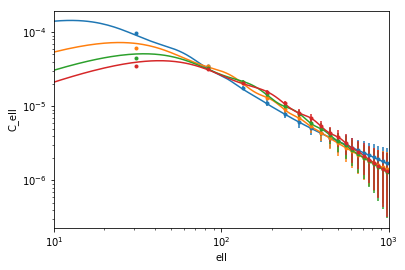

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)

N_z = []
spectra = []
errors = []

# Z sample values
z = np.arange(0., 3.0, 0.01)

for i in range(nbin):
    # Construct n(z)
    mean_z = 0.3*(1+i)
    sigma_z = 0.05
    n_z = np.exp(-0.5*(z - mean_z)**2 / sigma_z**2)
    N_z.append(n_z)
    
    # Use a constant bias in each bin and make a tracer
    bias = np.ones_like(z) * 1.5*(mean_z/0.3)**0.5
    T = ccl.NumberCountsTracer(cosmo, False, (z,N_z[i]), (z, bias))

    # Calculate C_ell over the full ell range (for each integer value)
    ell = np.arange(ell_max+1)
    cl = ccl.angular_cl(cosmo, T, T, ell)

    # Apply window functions to get band powers
    cb = []
    for m,M in window_ranges:
        cb.append(np.mean(cl[m:M]))
    spectra.append(cb)

    # Plot each tomographic bin
    errors.append(np.ones_like(cb)*1e-6)
    line, = loglog(ell, cl)
    errorbar(effective_ell, cb, yerr=errors[-1], fmt='.', color=line.get_color())
    xlim(10,ell_max)
    xlabel("ell")
    ylabel("C_ell")

variances = np.concatenate(errors)**2

# Constructing the data set object

We now construct the Sacc data set object, using all the different ingredients.

We initially start with a blank data set object, and gradually fill it in.

In [6]:
S = sacc.Sacc()

Save some metadata.  This is all stored in FITS headers, so can only be simple scalar values

In [7]:
S.metadata['nbin_lens'] = 4
S.metadata['nbin_source'] = 0 
S.metadata['creator'] = 'Beloved User'
S.metadata['creation'] = datetime.datetime.now().isoformat()
S.metadata['info'] = 'Theory predictions using CCL'

Now we create some window objects representing the window functions.

As an example here we will also create some window functions for mock observations of a pretend new data type.

In [8]:
# In this case we use the same top-hat window for each tomographic bin.
# In reality we would probably use a different window for each
# pair of bins, empirically determined.
windows = [sacc.TopHatWindow(m,M) for m,M in window_ranges]

# Imaginary new statistic's window that I just made up
windows_1pt = []
for i in range(5):
    v = np.arange(i*10., (i+1)*10.)
    w = np.random.uniform(size=10)**2
    windows_1pt.append(sacc.Window(v,w))

Now we add the tracers and data points

In [9]:
for i in range(nbin):
    # Add the appropriate tracer
    S.add_tracer('NZ', f'bin_{i}', z, N_z[i])
    # Get the binned spectrum values
    cb = spectra[i]
    # In this case we are just doing LSS, so
    # there is just a single bin, repeated.
    bin_name = f'bin_{i}'

    # Add the values
    S.add_ell_cl(galaxy_density_cl, bin_name, bin_name, effective_ell, cb, window=windows)

We an specify Sacc covariances in several ways.  If we supply a 1D vector it will be interpreted as the variances of a diagonal covariances

In [10]:
S.add_covariance(variances)

We can tag data points with additional information if we want

In [11]:
# Just for fun we add arbitrary tags to a few data points
S.data[4].tags['flag'] = 42
S.data[10].tags['flag'] = 42

In [12]:
# An example cut
cut = S.indices("galaxy_density_cl", ell__gt=900)
print(f"Removing {len(cut)} data points")
S.remove_indices(cut)

# Could also write this to do the cut directly.
# This won't remove anything because we just did the same cut above
S.remove_selection('galaxy_density_cl', ell_gt=900)


Removing 8 data points


/Users/jaz/src/Sacc/sacc/sacc.py:340: UserWarning: Empty index selected
  warnings.warn("Empty index selected")


# I/O

Let's save to a FITS file now and reload.

In [13]:
S.save_fits('tmp.fits', overwrite=True)

In [14]:
S2 = sacc.Sacc.load_fits('tmp.fits')

# Plotting

Let's plot the original data file and the re-loaded one, to check they agree.

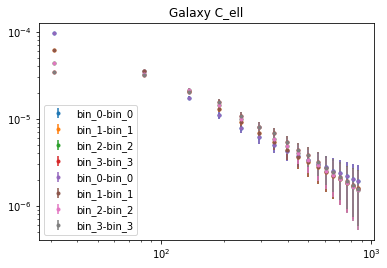

In [15]:
# First the original data set
for b1, b2 in S.get_tracer_combinations('galaxy_density_cl'):
    # We can use this convenience function to pull out the ell values we want
    ell, cl, covmat = S.get_ell_cl('galaxy_density_cl', b1, b2, return_cov=True)
    errorbar(ell, cl, yerr=covmat.diagonal()**0.5, fmt='.', label=f'{b1}-{b2}')
    xscale('log')
    yscale('log')
title("Galaxy C_ell")
legend()

# Now another plot of the second data set that we saved and loaded
for b1, b2 in S2.get_tracer_combinations('galaxy_density_cl'):
    ell, cl, covmat = S2.get_ell_cl('galaxy_density_cl', b1, b2, return_cov=True)
    errorbar(ell, cl, yerr=covmat.diagonal()**0.5, fmt='.', label=f'{b1}-{b2}')
    xscale('log')
    yscale('log')
title("Galaxy C_ell")
legend()
